# Ventaneo de Señales
## Procesamiento Digital de Señales

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft
import sounddevice as sd
import IPython.display as ipd

from labs.transformada_fourier import (
    TransformadaFourier,
    aplicar_ruido,
)

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## 1. Fundamentos Teóricos del Ventaneo

### ¿Por qué necesitamos ventanas?

Cuando aplicamos la DFT a una señal, implícitamente estamos asumiendo que la señal es **periódica**. Si la señal no es exactamente periódica en el intervalo de análisis, se produce **discontinuidad** en los extremos, lo que causa **fuga espectral**.

### Tipos de ventanas más comunes:

1. **Rectangular**: $w[n] = 1$ para $0 \leq n \leq N-1$

2. **Hann**: $w[n] = 0.5 - 0.5\cos\left(\frac{2\pi n}{N-1}\right)$

3. **Hamming**: $w[n] = 0.54 - 0.46\cos\left(\frac{2\pi n}{N-1}\right)$

4. **Blackman**: $w[n] = 0.42 - 0.5\cos\left(\frac{2\pi n}{N-1}\right) + 0.08\cos\left(\frac{4\pi n}{N-1}\right)$

## 2. Comparación Visual de Ventanas

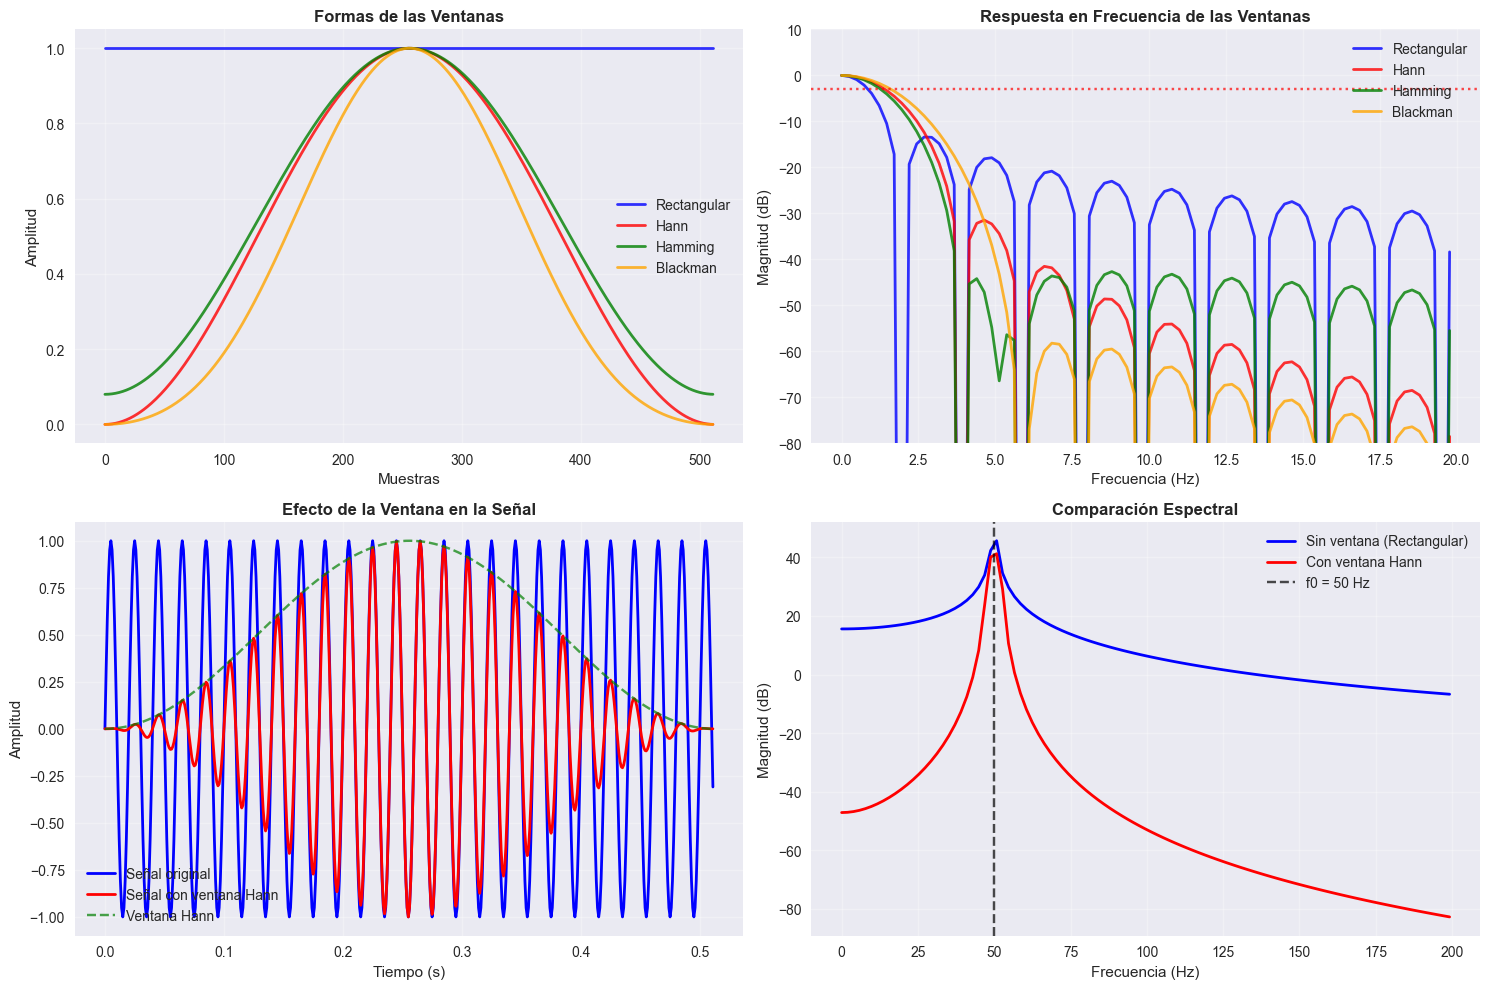

In [23]:
N = 512
fs = 1000
tf = TransformadaFourier(fs)

ventanas = [None, 'hann', 'hamming', 'blackman']
nombres_ventanas = ['Rectangular', 'Hann', 'Hamming', 'Blackman']
colores = ['blue', 'red', 'green', 'orange']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

ax1 = axes[0, 0]
n_ventana = np.arange(N)
for i, (ventana, nombre, color) in enumerate(zip(ventanas, nombres_ventanas, colores)):
    if ventana is None:
        w = np.ones(N)
    else:
        w = signal.get_window(ventana, N)

    ax1.plot(n_ventana, w, label=nombre, color=color, linewidth=2, alpha=0.8)

ax1.set_title('Formas de las Ventanas', fontsize=12, fontweight='bold')
ax1.set_xlabel('Muestras')
ax1.set_ylabel('Amplitud')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
for i, (ventana, nombre, color) in enumerate(zip(ventanas, nombres_ventanas, colores)):
    if ventana is None:
        w = np.ones(N)
    else:
        w = signal.get_window(ventana, N)

    N_pad = 4096
    w_pad = np.zeros(N_pad)
    w_pad[:N] = w

    W = fft(w_pad)
    freqs_w = np.fft.fftfreq(N_pad, 1/fs)

    idx_pos = (freqs_w >= 0) & (freqs_w <= 20)
    freqs_pos = freqs_w[idx_pos]
    W_pos = W[idx_pos]
    mag_W_db = 20 * np.log10(np.abs(W_pos) / np.max(np.abs(W_pos)) + 1e-12)

    ax2.plot(freqs_pos, mag_W_db, label=nombre, color=color, linewidth=2, alpha=0.8)

    if ventana == 'blackman':
        from scipy.signal import find_peaks
        mag_lin = np.abs(W_pos)
        peaks, properties = find_peaks(mag_lin, height=np.max(mag_lin) * 0.05)

        if len(peaks) > 0:
            peak_heights = mag_lin[peaks]
            order = np.argsort(peak_heights)[::-1]
            top_peaks = peaks[order][:8]

            for p in top_peaks:
                freq_p = freqs_pos[p]
                mag_db_p = mag_W_db[p]
                ax2.plot(freq_p, mag_db_p, 'ko', markersize=4)
                ax2.text(freq_p, mag_db_p + 1.5, f'{freq_p:.2f} Hz',
                         ha='center', va='bottom', fontsize=8, rotation=45)

ax2.set_title('Respuesta en Frecuencia de las Ventanas', fontsize=12, fontweight='bold')
ax2.set_xlabel('Frecuencia (Hz)')
ax2.set_ylabel('Magnitud (dB)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim([-80, 10])
ax2.axhline(y=-3, color='red', linestyle=':', alpha=0.7, label='-3dB')

ax3 = axes[1, 0]
t = np.arange(N) / fs
f0 = 50  # Hz
x = np.sin(2 * np.pi * f0 * t)

w_hann = signal.get_window('hann', N)
x_windowed = x * w_hann

lastsample = 800
ax3.plot(t[:lastsample], x[:lastsample], 'b-', label='Señal original', linewidth=2)
ax3.plot(t[:lastsample], x_windowed[:lastsample], 'r-', label='Señal con ventana Hann', linewidth=2)
ax3.plot(t[:lastsample], w_hann[:lastsample], 'g--', alpha=0.7, label='Ventana Hann')
ax3.set_title('Efecto de la Ventana en la Señal', fontweight='bold')
ax3.set_xlabel('Tiempo (s)')
ax3.set_ylabel('Amplitud')
ax3.legend()
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 1]
freqs = np.fft.fftfreq(N, 1/fs)
idx_pos = (freqs >= 0) & (freqs <= 200)

X_rect = fft(x)
X_hann = fft(x_windowed)

ax4.plot(freqs[idx_pos], 20*np.log10(np.abs(X_rect[idx_pos]) + 1e-12),
         'b-', label='Sin ventana (Rectangular)', linewidth=2)
ax4.plot(freqs[idx_pos], 20*np.log10(np.abs(X_hann[idx_pos]) + 1e-12),
         'r-', label='Con ventana Hann', linewidth=2)
ax4.axvline(x=f0, color='black', linestyle='--', alpha=0.7, label=f'f0 = {f0} Hz')
ax4.set_title('Comparación Espectral', fontweight='bold')
ax4.set_xlabel('Frecuencia (Hz)')
ax4.set_ylabel('Magnitud (dB)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Análisis de Resolución Frecuencial vs Fuga Espectral

In [32]:
def generar_señal_test(fs=1000, N=512, f1=64, f2=68, snr=20):
    t = np.arange(N) / fs
    señal = np.sin(2*np.pi*f1*t) + 0.8*np.sin(2*np.pi*f2*t)
    potencia_señal = np.mean(señal**2)
    potencia_ruido = potencia_señal / (10**(snr/10))
    ruido = np.sqrt(potencia_ruido) * np.random.randn(len(t))
    return t, señal + ruido, f2 - f1


def plotear_espectro(ax, x, ventana, color, f1, f2, titulo=None, mostrar_freq=True):
    freqs, magnitud, _ = tf.fft_analysis(x, ventana=ventana)
    idx_pos = (freqs >= 50) & (freqs <= 85)

    ax.plot(freqs[idx_pos], 20*np.log10(magnitud[idx_pos] + 1e-12),
            color=color, linewidth=2.5, alpha=0.8)

    if mostrar_freq:
        ax.axvline(x=f1, color='darkred', linestyle='--', alpha=0.7, linewidth=1.5)
        ax.axvline(x=f2, color='darkred', linestyle='--', alpha=0.7, linewidth=1.5)

    if titulo:
        ax.set_title(titulo, fontsize=10, fontweight='bold')
    ax.set_xlabel('Frecuencia (Hz)')
    ax.set_ylabel('Magnitud (dB)')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([-60, 60])


def plotear_ancho_lobulos(ax, nombres, anchos, colores, fs, N):
    bars = ax.bar(nombres, anchos, color=colores, alpha=0.7,
                  edgecolor='black', linewidth=1)

    resolucion_base = fs / N
    ax.axhline(y=resolucion_base, color='red', linestyle=':', alpha=0.8,
               linewidth=2, label=f'Resolución base: {resolucion_base:.2f} Hz')

    ax.set_title('Ancho del Lóbulo Principal', fontsize=10, fontweight='bold')
    ax.set_ylabel('Ancho (Hz)')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend(fontsize=8)

    for bar, ancho in zip(bars, anchos):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{ancho:.1f}', ha='center', va='bottom',
                fontsize=9, fontweight='bold')


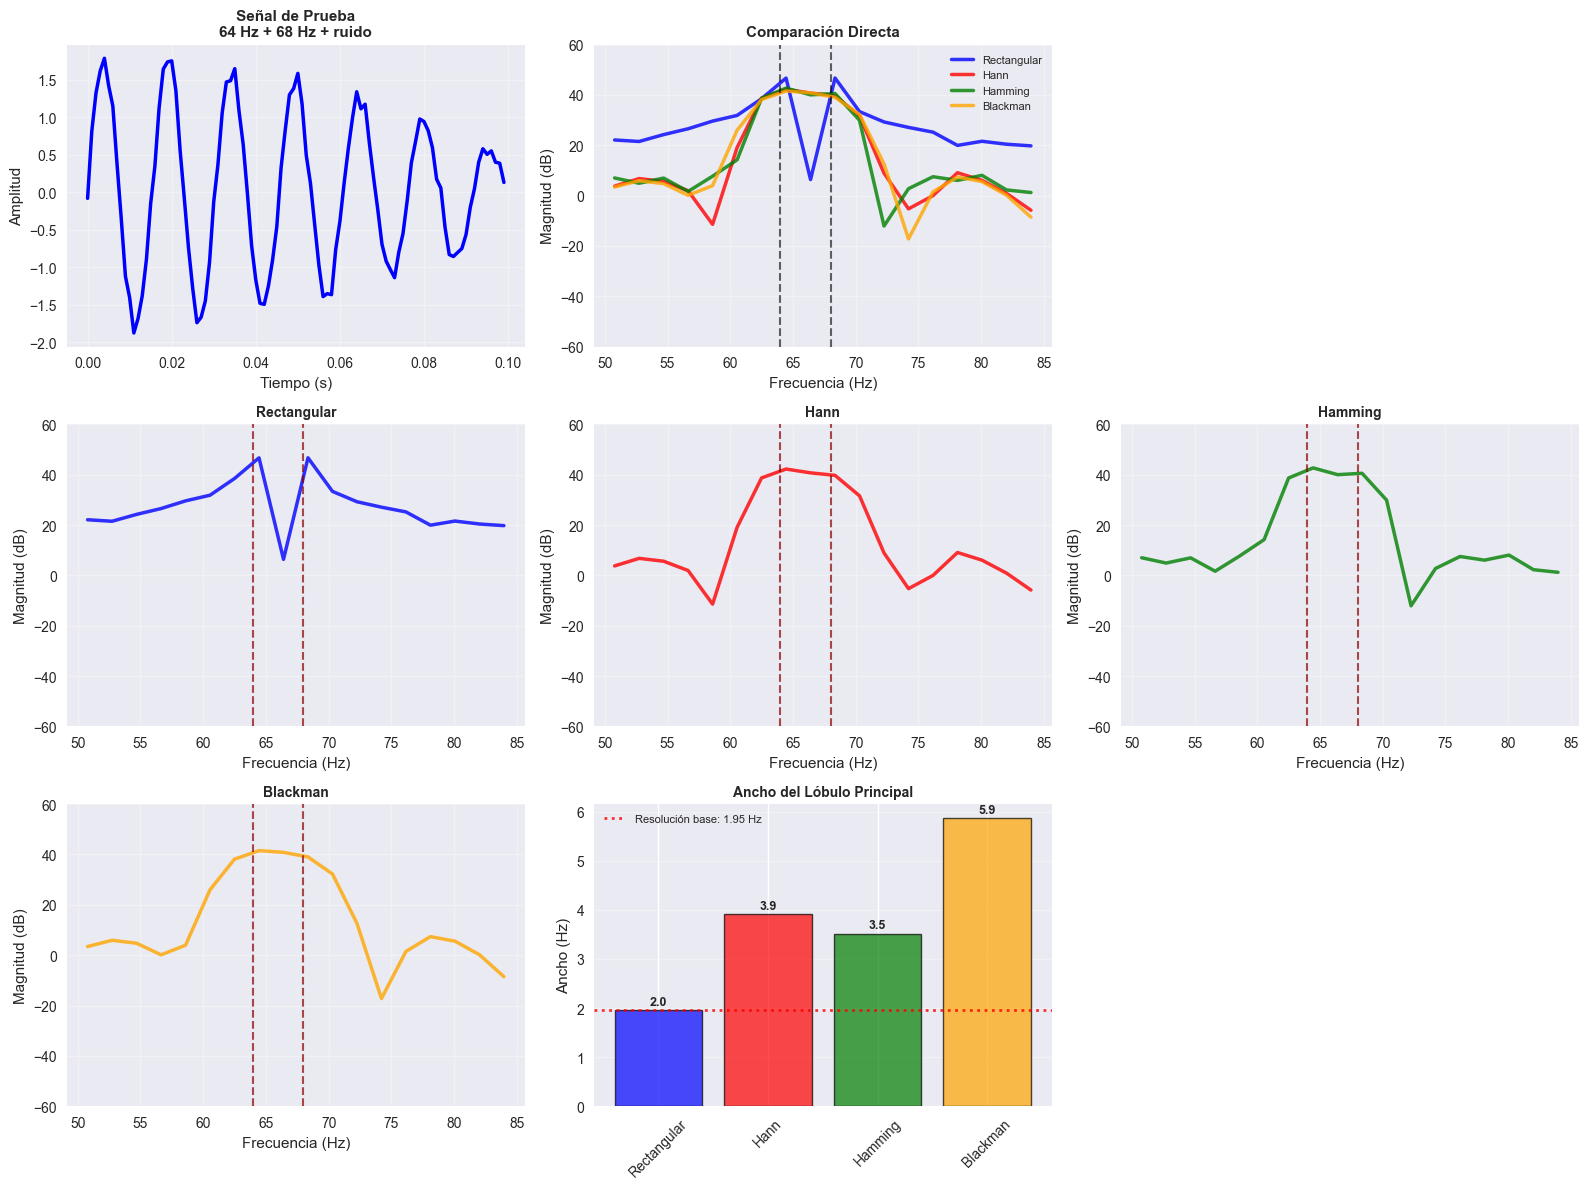

In [ ]:
fs, N = 1000, 512
f1, f2 = 64, 68
ventanas = [None, 'hann', 'hamming', 'blackman']
nombres_ventanas = ['Rectangular', 'Hann', 'Hamming', 'Blackman']
colores = ['blue', 'red', 'green', 'orange']

# Ancho del lóbulo principal = Factor × (fs/N)
# Rectangular: 1.0 × (1000/512) = 1.95 Hz
# Hann: 2.0 × (1000/512) = 3.91 Hz
# Hamming: 1.8 × (1000/512) = 3.52 Hz
# Blackman: 3.0 × (1000/512) = 5.86 Hz
factores_teoricos = {'Rectangular': 1.0, 'Hann': 2.0, 'Hamming': 1.8, 'Blackman': 3.0}


t, x, separacion = generar_señal_test(fs, N, f1, f2)

fig = plt.figure(figsize=(16, 12))

ax_señal = plt.subplot(3, 3, 1)
ax_señal.plot(t[:100], x[:100], 'b-', linewidth=2.5)
ax_señal.set_title(f'Señal de Prueba\n{f1} Hz + {f2} Hz + ruido',
                   fontsize=11, fontweight='bold')
ax_señal.set_xlabel('Tiempo (s)')
ax_señal.set_ylabel('Amplitud')
ax_señal.grid(True, alpha=0.3)

ax_comp = plt.subplot(3, 3, 2)
for ventana, nombre, color in zip(ventanas, nombres_ventanas, colores):
    plotear_espectro(ax_comp, x, ventana, color, f1, f2, mostrar_freq=False)

ax_comp.axvline(x=f1, color='black', linestyle='--', alpha=0.6, linewidth=1.5)
ax_comp.axvline(x=f2, color='black', linestyle='--', alpha=0.6, linewidth=1.5)
ax_comp.set_title('Comparación Directa', fontsize=11, fontweight='bold')
ax_comp.legend(nombres_ventanas, fontsize=8, loc='upper right')
ax_comp.set_ylim([-60, 60])

for i, (ventana, nombre, color) in enumerate(zip(ventanas, nombres_ventanas, colores)):
    ax = plt.subplot(3, 3, 4 + i)
    plotear_espectro(ax, x, ventana, color, f1, f2, titulo=nombre)

ax_res = plt.subplot(3, 3, 8)
anchos_lobulo = [factores_teoricos[nombre] * fs / N for nombre in nombres_ventanas]
plotear_ancho_lobulos(ax_res, nombres_ventanas, anchos_lobulo, colores, fs, N)

plt.tight_layout()
plt.show()

## 4. Análisis de Frames con Ventaneo

In [34]:
FS = 16000
DURATION = 5
FRAME_SIZE = 0.05
FRAME_STRIDE = 0.01

def grabar_voz(fs=FS, duration=DURATION):
    print("Grabando tu voz...")
    voz = sd.rec(int(duration * fs), samplerate=fs, channels=1)
    sd.wait()
    voz = voz.flatten()
    print("Grabación terminada")
    ipd.display(ipd.Audio(voz, rate=fs))
    return voz

def generar_señal_sintetica(fs=FS, duration=DURATION):
    t = np.arange(0, duration, 1/fs)

    señal = (
        np.sin(2*np.pi*100*t) * np.exp(-t/2) +
        0.5 * np.sin(2*np.pi*200*t) * (t < duration/2) +
        0.3 * np.sin(2*np.pi*400*t) * (t > duration/2) +
        0.1 * np.random.randn(len(t))
    )

    return señal

def crear_frames(signal, frame_size, stride, fs):
    frame_length = int(frame_size * fs)
    frame_step = int(stride * fs)
    signal_length = len(signal)
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step)) + 1
    pad_signal_length = num_frames * frame_step + frame_length
    pad_signal = np.append(signal, np.zeros(pad_signal_length - signal_length))

    indices = np.tile(np.arange(frame_length), (num_frames,1)) + \
              np.tile(np.arange(0, num_frames*frame_step, frame_step), (frame_length,1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    hamming_window = np.hamming(frame_length)
    frames_windowed = frames * hamming_window
    return frames, frames_windowed, frame_length, frame_step, num_frames

Señal dividida en 496 frames
Longitud de cada frame: 800 muestras (50.0 ms)
Solapamiento: 160 muestras (10.0 ms)


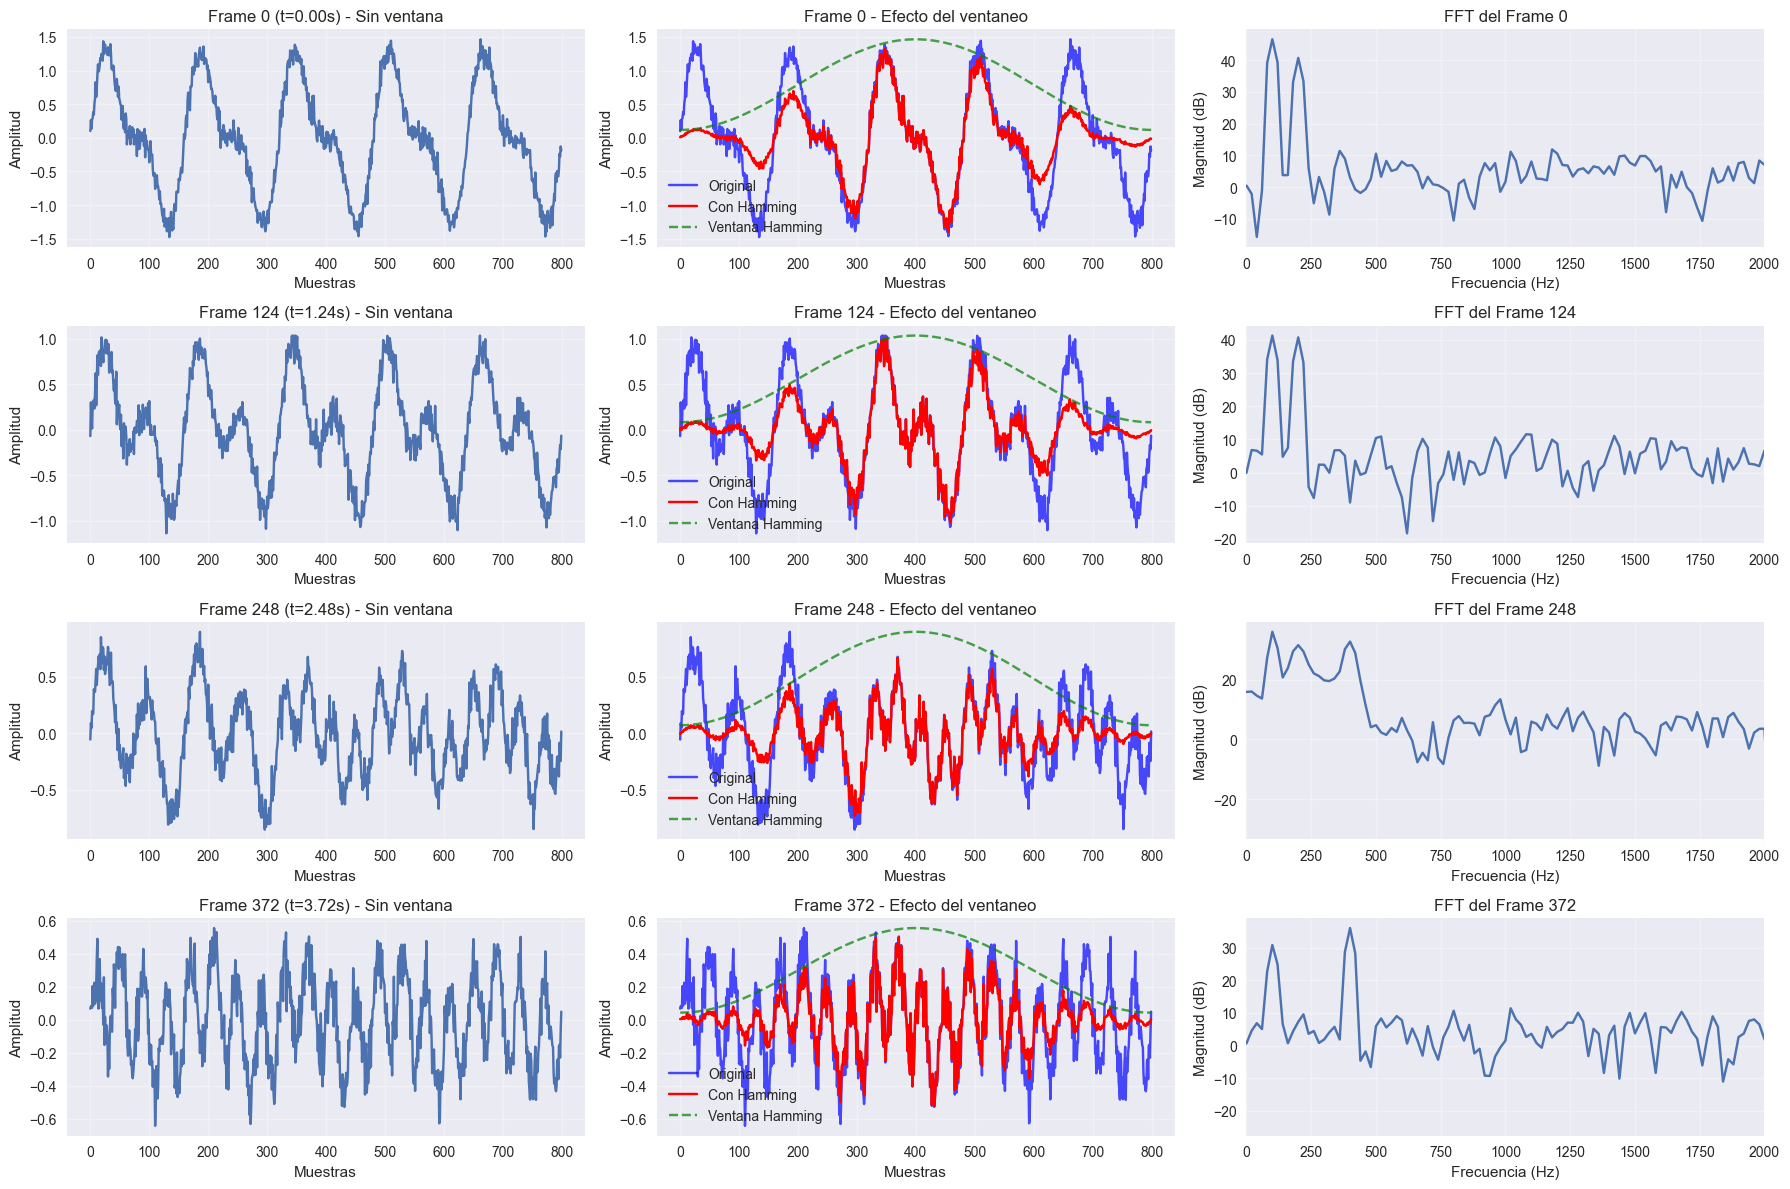

In [35]:
voz = generar_señal_sintetica()

frames, frames_windowed, frame_length, frame_step, num_frames = crear_frames(
    voz, FRAME_SIZE, FRAME_STRIDE, FS
)

print(f"Señal dividida en {num_frames} frames")
print(f"Longitud de cada frame: {frame_length} muestras ({FRAME_SIZE*1000:.1f} ms)")
print(f"Solapamiento: {frame_step} muestras ({FRAME_STRIDE*1000:.1f} ms)")

frames_a_mostrar = [0, num_frames//4, num_frames//2, 3*num_frames//4]

fig, axes = plt.subplots(len(frames_a_mostrar), 3, figsize=(18, 12))

for i, frame_idx in enumerate(frames_a_mostrar):
    if frame_idx >= num_frames:
        frame_idx = num_frames - 1

    tiempo_frame = frame_idx * frame_step / FS

    axes[i, 0].plot(frames[frame_idx])
    axes[i, 0].set_title(f'Frame {frame_idx} (t={tiempo_frame:.2f}s) - Sin ventana')
    axes[i, 0].set_xlabel('Muestras')
    axes[i, 0].set_ylabel('Amplitud')
    axes[i, 0].grid(True, alpha=0.3)

    axes[i, 1].plot(frames[frame_idx], 'b-', alpha=0.7, label='Original')
    axes[i, 1].plot(frames_windowed[frame_idx], 'r-', label='Con Hamming')
    axes[i, 1].plot(np.hamming(frame_length) * np.max(frames[frame_idx]),
                   'g--', alpha=0.7, label='Ventana Hamming')
    axes[i, 1].set_title(f'Frame {frame_idx} - Efecto del ventaneo')
    axes[i, 1].set_xlabel('Muestras')
    axes[i, 1].set_ylabel('Amplitud')
    axes[i, 1].legend()
    axes[i, 1].grid(True, alpha=0.3)

    fft_vals = np.fft.rfft(frames_windowed[frame_idx])
    fft_freqs = np.fft.rfftfreq(frame_length, d=1/FS)

    axes[i, 2].plot(fft_freqs, 20*np.log10(np.abs(fft_vals) + 1e-12))
    axes[i, 2].set_title(f'FFT del Frame {frame_idx}')
    axes[i, 2].set_xlabel('Frecuencia (Hz)')
    axes[i, 2].set_ylabel('Magnitud (dB)')
    axes[i, 2].grid(True, alpha=0.3)
    axes[i, 2].set_xlim(0, 2000)

plt.tight_layout()
plt.show()

## 5. Espectrograma con Diferentes Ventanas

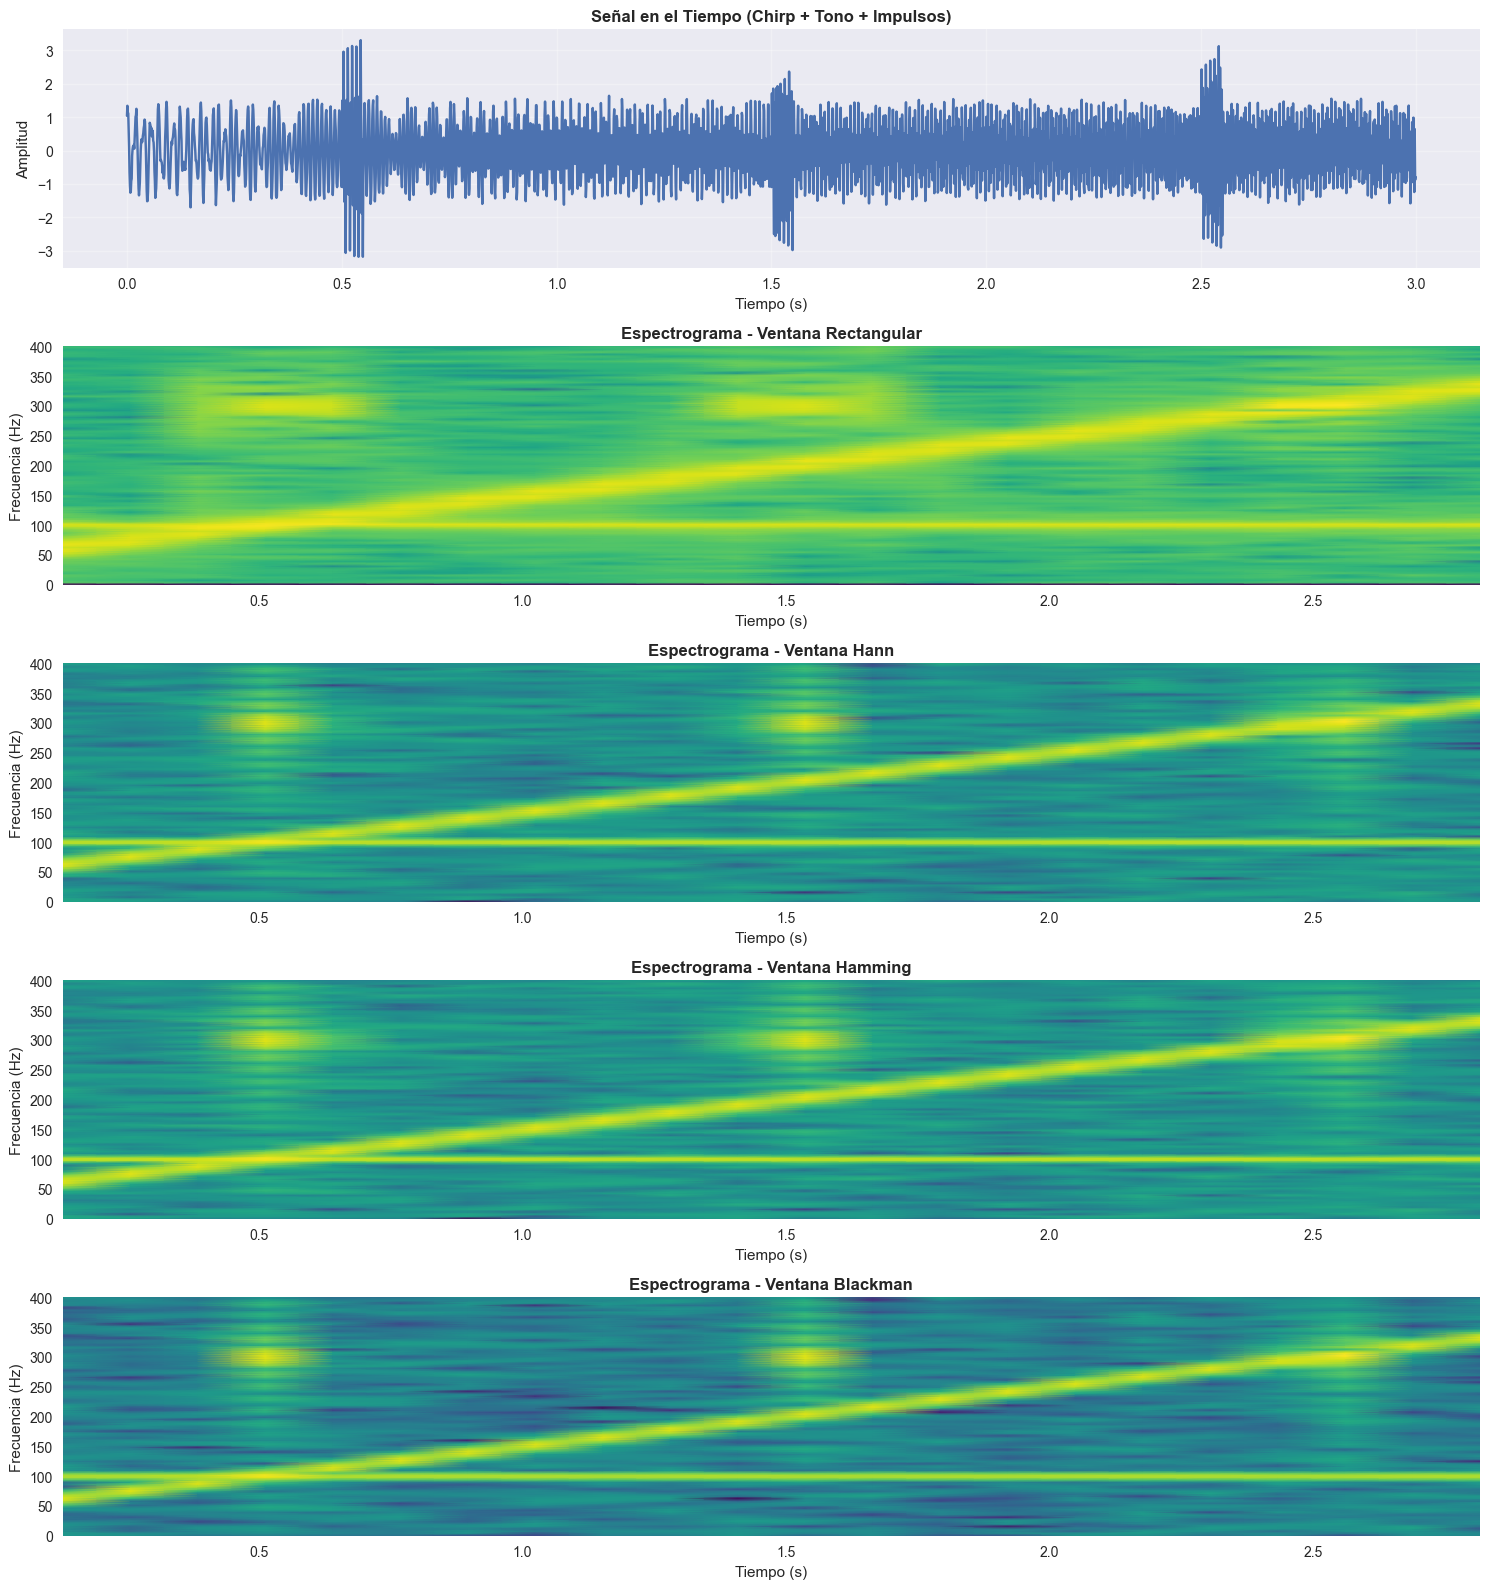

In [37]:
fs = 1000
duracion = 3
t = np.arange(0, duracion, 1/fs)

señal_chirp = signal.chirp(t, f0=50, f1=200, t1=duracion/2, method='linear')
señal_tono = 0.5 * np.sin(2*np.pi*100*t)

impulsos = np.zeros_like(t)
idx_impulsos = [int(0.5*fs), int(1.5*fs), int(2.5*fs)]
for idx in idx_impulsos:
    if idx < len(impulsos):
        impulsos[idx:idx+50] = 2 * np.sin(2*np.pi*300*t[idx:idx+50])

señal_compleja = señal_chirp + señal_tono + impulsos
señal_final = aplicar_ruido(señal_compleja, snr_db=20)

ventanas_spec = ['rectangular', 'hann', 'hamming', 'blackman']
nombres_spec = ['Rectangular', 'Hann', 'Hamming', 'Blackman']

fig, axes = plt.subplots(len(ventanas_spec) + 1, 1, figsize=(15, 16))

axes[0].plot(t, señal_final)
axes[0].set_title('Señal en el Tiempo (Chirp + Tono + Impulsos)', fontweight='bold')
axes[0].set_xlabel('Tiempo (s)')
axes[0].set_ylabel('Amplitud')
axes[0].grid(True, alpha=0.3)

tf_spec = TransformadaFourier(fs)

for i, (ventana, nombre) in enumerate(zip(ventanas_spec, nombres_spec)):
    if ventana == 'rectangular':
        ventana_scipy = 'boxcar'
    else:
        ventana_scipy = ventana

    f_spec, t_spec, Sxx = tf_spec.espectrograma(
        señal_final,
        nperseg=256,
        noverlap=128,
        ventana=ventana_scipy
    )

    im = axes[i+1].pcolormesh(t_spec, f_spec, 10*np.log10(Sxx + 1e-12),
                             shading='gouraud', cmap='viridis')
    axes[i+1].set_title(f'Espectrograma - Ventana {nombre}', fontweight='bold')
    axes[i+1].set_xlabel('Tiempo (s)')
    axes[i+1].set_ylabel('Frecuencia (Hz)')
    axes[i+1].set_ylim(0, 400)

    # if i == len(ventanas_spec) - 1:
    #     cbar = plt.colorbar(im, ax=axes[i+1])
    #     cbar.set_label('Potencia (dB)')

plt.tight_layout()
plt.show()

## 6. Creación de un acorde

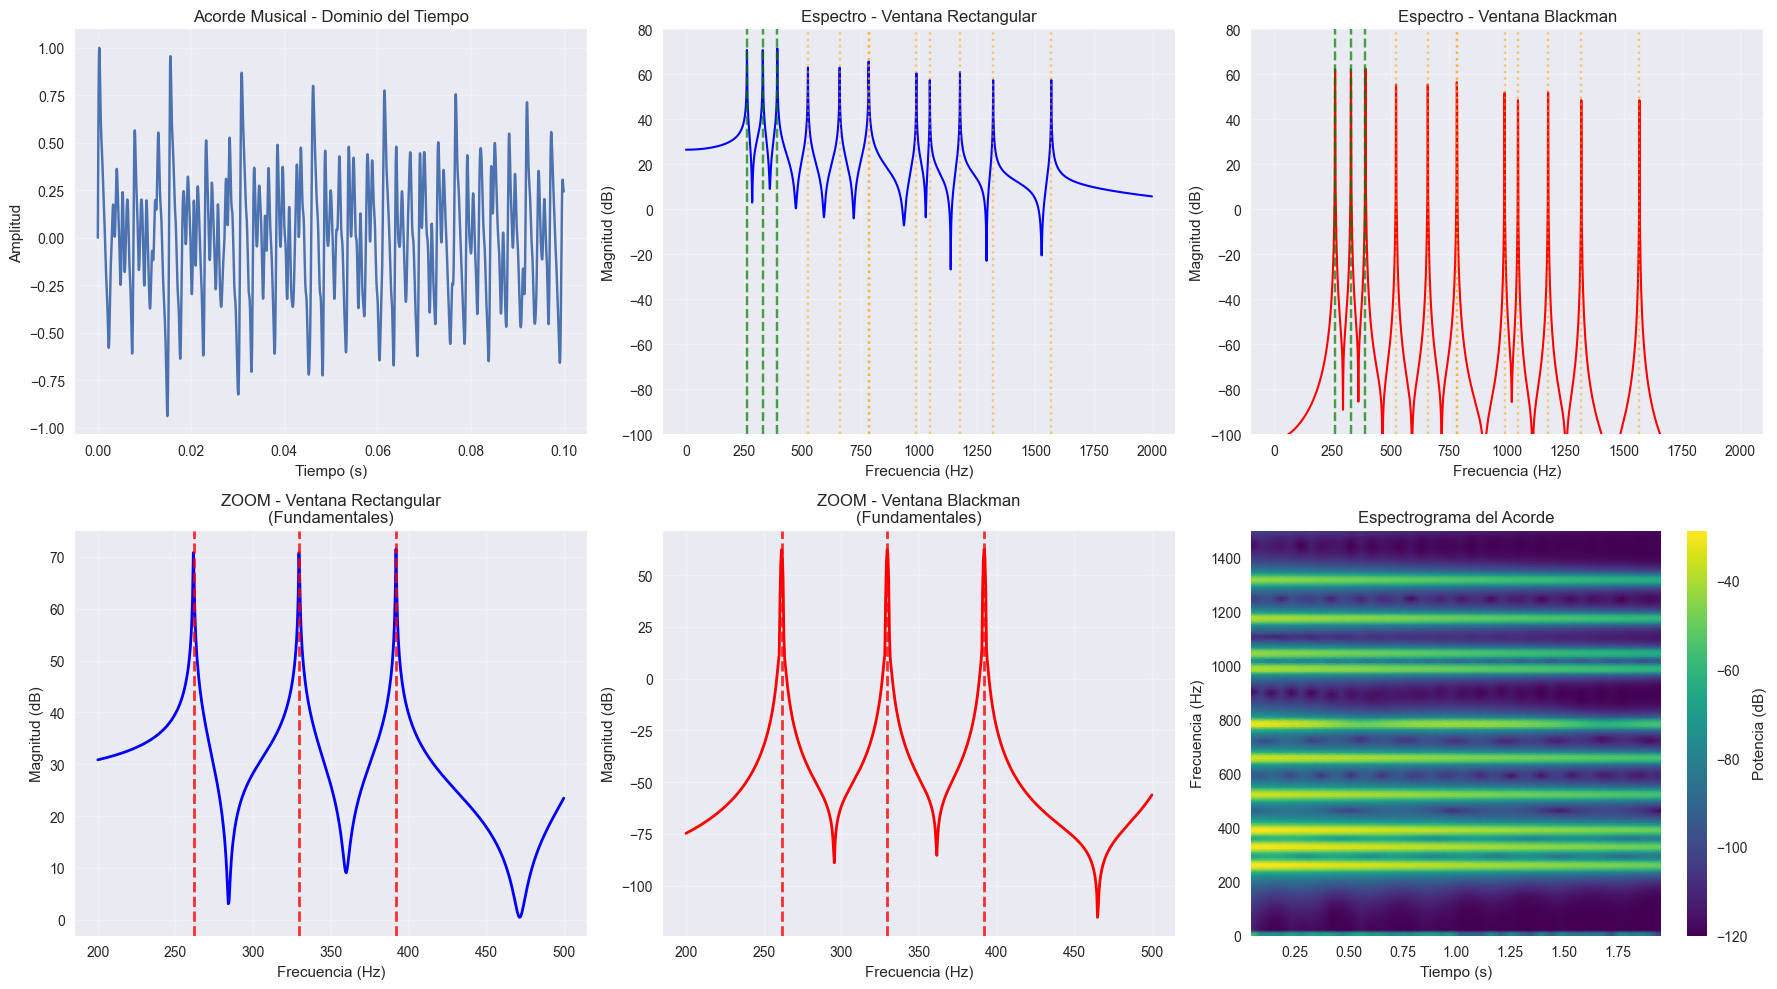

In [40]:
fs = 44100
duracion = 2
t = np.arange(0, duracion, 1/fs)

freqs_fundamentales = [261.63, 329.63, 392.00]

acorde = np.zeros_like(t)
for f0 in freqs_fundamentales:
    acorde += np.sin(2*np.pi*f0*t)
    acorde += 0.5 * np.sin(2*np.pi*2*f0*t)
    acorde += 0.3 * np.sin(2*np.pi*3*f0*t)
    acorde += 0.2 * np.sin(2*np.pi*4*f0*t)

envolvente = np.exp(-t/0.8)
acorde = acorde * envolvente

acorde = acorde / np.max(np.abs(acorde))

tf_audio = TransformadaFourier(fs)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes[0, 0].plot(t[:int(0.1*fs)], acorde[:int(0.1*fs)])
axes[0, 0].set_title('Acorde Musical - Dominio del Tiempo')
axes[0, 0].set_xlabel('Tiempo (s)')
axes[0, 0].set_ylabel('Amplitud')
axes[0, 0].grid(True, alpha=0.3)

ventanas_comp = [None, 'blackman']
nombres_comp = ['Rectangular', 'Blackman']
colores_comp = ['blue', 'red']

for i, (ventana, nombre, color) in enumerate(zip(ventanas_comp, nombres_comp, colores_comp)):
    freqs, magnitud, _ = tf_audio.fft_analysis(acorde, ventana=ventana)

    idx_full = (freqs >= 0) & (freqs <= 2000)
    axes[0, i+1].plot(freqs[idx_full], 20*np.log10(magnitud[idx_full] + 1e-12),
                     color=color, linewidth=1.5)

    for j, f in enumerate(freqs_fundamentales):
        axes[0, i+1].axvline(x=f, color='green', linestyle='--', alpha=0.7)
        for harm in [2, 3, 4]:
            if harm * f <= 2000:
                axes[0, i+1].axvline(x=harm*f, color='orange',
                                   linestyle=':', alpha=0.5)

    axes[0, i+1].set_title(f'Espectro - Ventana {nombre}')
    axes[0, i+1].set_xlabel('Frecuencia (Hz)')
    axes[0, i+1].set_ylabel('Magnitud (dB)')
    axes[0, i+1].grid(True, alpha=0.3)
    axes[0, i+1].set_ylim([-100, 80])

for i, (ventana, nombre, color) in enumerate(zip(ventanas_comp, nombres_comp, colores_comp)):
    freqs, magnitud, _ = tf_audio.fft_analysis(acorde, ventana=ventana)

    idx_zoom = (freqs >= 200) & (freqs <= 500)
    axes[1, i].plot(freqs[idx_zoom], 20*np.log10(magnitud[idx_zoom] + 1e-12),
                   color=color, linewidth=2)

    for f in freqs_fundamentales:
        if 200 <= f <= 500:
            axes[1, i].axvline(x=f, color='red', linestyle='--',
                             alpha=0.8, linewidth=2)

    axes[1, i].set_title(f'ZOOM - Ventana {nombre}\n(Fundamentales)')
    axes[1, i].set_xlabel('Frecuencia (Hz)')
    axes[1, i].set_ylabel('Magnitud (dB)')
    axes[1, i].grid(True, alpha=0.3)

f_spec, t_spec, Sxx = tf_audio.espectrograma(acorde, nperseg=4096, noverlap=2048,
                                            ventana='hann')
im = axes[1, 2].pcolormesh(t_spec, f_spec, 10*np.log10(Sxx + 1e-12),
                          shading='gouraud', cmap='viridis')
axes[1, 2].set_title('Espectrograma del Acorde')
axes[1, 2].set_xlabel('Tiempo (s)')
axes[1, 2].set_ylabel('Frecuencia (Hz)')
axes[1, 2].set_ylim(0, 1500)
plt.colorbar(im, ax=axes[1, 2], label='Potencia (dB)')

plt.tight_layout()
plt.show()

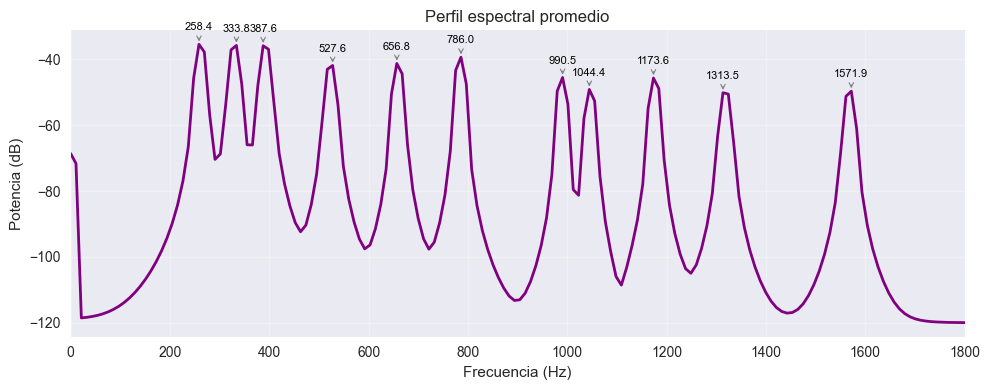

In [31]:
from scipy.signal import find_peaks

potencia_prom = np.mean(Sxx, axis=1)
potencia_db = 10*np.log10(potencia_prom + 1e-12)

peaks, _ = find_peaks(potencia_db, height=-60, distance=5)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(f_spec, potencia_db, color='purple', linewidth=2)

for p in peaks:
    if f_spec[p] <= 1800:
        ax.annotate(f"{f_spec[p]:.1f}",
                    xy=(f_spec[p], potencia_db[p]),
                    xytext=(0, 10),
                    textcoords="offset points",
                    ha='center', fontsize=8,
                    color='black',
                    arrowprops=dict(arrowstyle="->", color='gray', lw=0.8))

ax.set_title("Perfil espectral promedio")
ax.set_xlabel("Frecuencia (Hz)")
ax.set_ylabel("Potencia (dB)")
ax.set_xlim(0, 1800)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [27]:
from IPython.display import Audio
Audio(acorde, rate=fs)

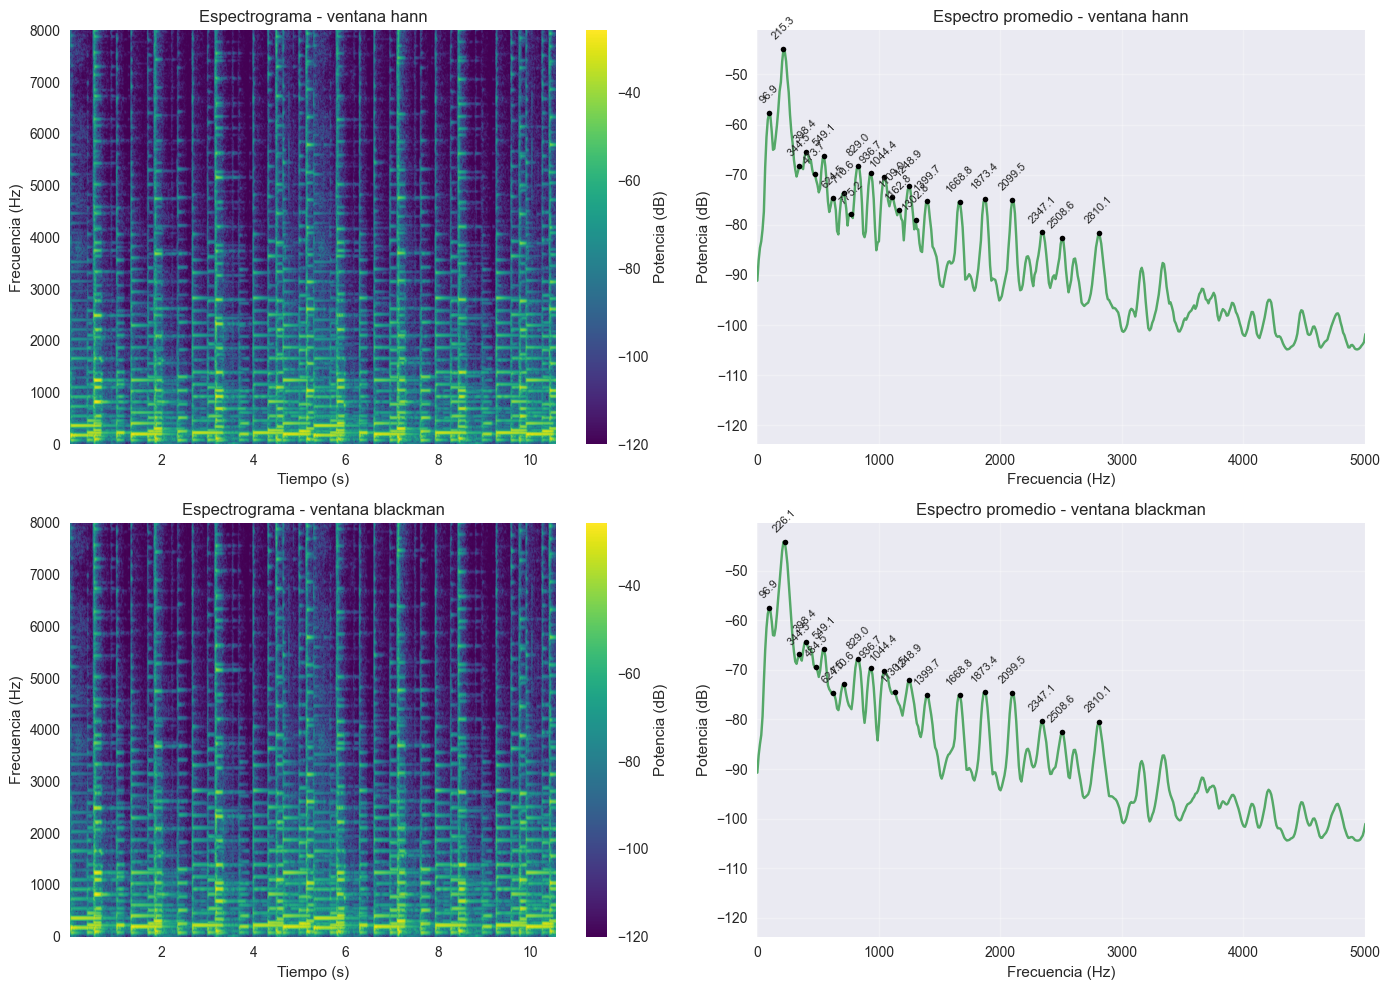

Top 12 frecuencias  por potencia media en el espectrograma (blackman):
 226.10 -> -44.16 dB
 215.33 -> -44.19 dB
 204.57 -> -45.96 dB
 236.87 -> -46.13 dB
 247.63 -> -48.63 dB
 193.80 -> -49.06 dB
 183.03 -> -52.37 dB
 258.40 -> -52.47 dB
 172.27 -> -55.42 dB
 269.17 -> -56.36 dB
  96.90 -> -57.58 dB
 107.67 -> -58.12 dB


In [ ]:
import librosa
from scipy.signal import stft, find_peaks


audio_path = 'guitar.mp3'
guitar, sr = librosa.load(audio_path, sr=None, mono=True)
source = 'librosa'

ipd.display(ipd.Audio(guitar, rate=sr))

nperseg = 2048
noverlap = 1536
nfft = 4096
ventanas_a_comparar = ['hann', 'blackman']


fig, axes = plt.subplots(len(ventanas_a_comparar), 2, figsize=(14, 5*len(ventanas_a_comparar)))

for i, win in enumerate(ventanas_a_comparar):
    f_spec, t_spec, Zxx = stft(guitar, fs=sr, window=win, nperseg=nperseg, noverlap=noverlap, nfft=nfft, boundary=None)
    Sxx = np.abs(Zxx)**2
    Sxx_db = 10 * np.log10(Sxx + 1e-12)

    im = axes[i, 0].pcolormesh(t_spec, f_spec, Sxx_db, shading='gouraud', cmap='viridis')
    axes[i, 0].set_title(f"Espectrograma - ventana {win}")
    axes[i, 0].set_xlabel('Tiempo (s)')
    axes[i, 0].set_ylabel('Frecuencia (Hz)')
    axes[i, 0].set_ylim(0, min(8000, sr/2))
    plt.colorbar(im, ax=axes[i, 0], label='Potencia (dB)')

    mean_db = Sxx_db.mean(axis=1)
    axes[i, 1].plot(f_spec, mean_db, color='C1')
    axes[i, 1].set_xlim(0, 5000)
    axes[i, 1].set_title(f'Espectro promedio - ventana {win}')
    axes[i, 1].set_xlabel('Frecuencia (Hz)')
    axes[i, 1].set_ylabel('Potencia (dB)')
    axes[i, 1].grid(True, alpha=0.3)

    thresh = np.max(mean_db) - 40
    peaks, props = find_peaks(mean_db, height=thresh, distance=5)

    top_peaks = peaks
    for p in top_peaks:
        fp = f_spec[p]
        dp = mean_db[p]
        if fp <= sr/2:
            axes[i, 1].plot(fp, dp, 'ko', markersize=4)
            axes[i, 1].text(fp, dp + 1.5, f"{fp:.1f}", ha='center', va='bottom', fontsize=8, rotation=45)

plt.tight_layout()
plt.show()

Ntop = 12
idx_sort = np.argsort(mean_db)[::-1][:Ntop]
print(f"Top {Ntop} frecuencias  por potencia media en el espectrograma ({ventanas_a_comparar[-1]}):")
for idx in idx_sort:
    print(f"{f_spec[idx]:7.2f} -> {mean_db[idx]:6.2f} dB")